In [45]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [46]:
from matplotlib import pyplot as plt
import numpy as np

In [47]:
num_classes = 3
# Hyper parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.0001

In [48]:
data_set_dir = "../input/face-mask-detection/Dataset/"
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [49]:
dataset = torchvision.datasets.ImageFolder(data_set_dir, transform=transform)

In [50]:
print(len(dataset))
from torch.utils.data import random_split

8982


In [51]:
test_size = 800
trains_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [trains_size, test_size])

In [52]:
from torch.utils.data.dataloader import DataLoader

In [53]:
trainloader = DataLoader(train_dataset, batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size*2)

In [54]:
def conv3x3(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        
def conv1x1(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)
    
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self,inplanes, planes, stride = 1, downsample = None):
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.drop = nn.Dropout(0.9)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out
        
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes = num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride = 2, padding = 2, bias= False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 1)
    
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def _make_layer(self, block, planes, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.inplanes, planes*block.expansion, stride),
                    nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,blocks):
            layers.append(block(self.inplanes, planes))
        
        return nn.Sequential(*layers)
        
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        
        return x

In [55]:
model = ResNet(BasicBlock, [1,1,1])

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [57]:
loss_list = []
train_acc = []
test_acc = []
use_gpu = False

total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        
        # images = images.view(batch_size,3,64,64)
        images = images.float()
        
        # gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 2 == 0:
            print("epoch: {} {}/{}".format(epoch,i,total_step))

    # train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            # images = images.view(batch_size,3,64,64)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    # test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # images = images.view(batch_size,3,64,64)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy test %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    loss_list.append(loss.item())


epoch: 0 0/82
epoch: 0 2/82
epoch: 0 4/82
epoch: 0 6/82
epoch: 0 8/82
epoch: 0 10/82
epoch: 0 12/82
epoch: 0 14/82
epoch: 0 16/82
epoch: 0 18/82
epoch: 0 20/82
epoch: 0 22/82
epoch: 0 24/82
epoch: 0 26/82
epoch: 0 28/82
epoch: 0 30/82
epoch: 0 32/82
epoch: 0 34/82
epoch: 0 36/82
epoch: 0 38/82
epoch: 0 40/82
epoch: 0 42/82
epoch: 0 44/82
epoch: 0 46/82
epoch: 0 48/82
epoch: 0 50/82
epoch: 0 52/82
epoch: 0 54/82
epoch: 0 56/82
epoch: 0 58/82
epoch: 0 60/82
epoch: 0 62/82
epoch: 0 64/82
epoch: 0 66/82
epoch: 0 68/82
epoch: 0 70/82
epoch: 0 72/82
epoch: 0 74/82
epoch: 0 76/82
epoch: 0 78/82
epoch: 0 80/82
Accuracy train 71 %
Accuracy test 74 %
epoch: 1 0/82
epoch: 1 2/82
epoch: 1 4/82
epoch: 1 6/82
epoch: 1 8/82
epoch: 1 10/82
epoch: 1 12/82
epoch: 1 14/82
epoch: 1 16/82
epoch: 1 18/82
epoch: 1 20/82
epoch: 1 22/82
epoch: 1 24/82
epoch: 1 26/82
epoch: 1 28/82
epoch: 1 30/82
epoch: 1 32/82
epoch: 1 34/82
epoch: 1 36/82
epoch: 1 38/82
epoch: 1 40/82
epoch: 1 42/82
epoch: 1 44/82
epoch: 1 46

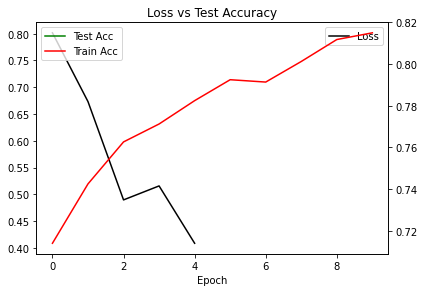

In [58]:
fig, ax1 = plt.subplots()
plt.plot(loss_list,label = "Loss",color = "black")
ax2 = ax1.twinx()
ax2.plot(np.array(test_acc)/100,label = "Test Acc",color="green")
ax2.plot(np.array(train_acc)/100,label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
fig.tight_layout()
plt.title("Loss vs Test Accuracy")
plt.show()

<AxesSubplot:>

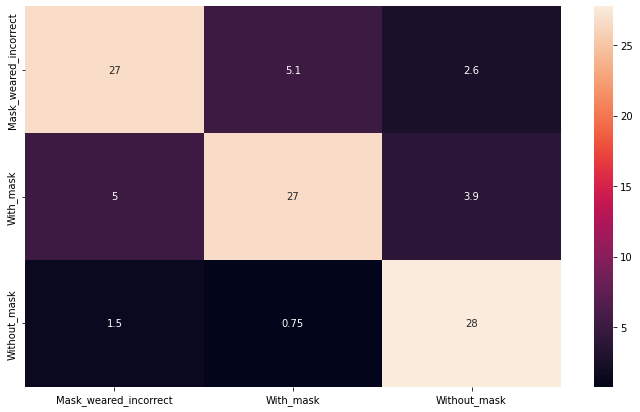

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Mask_weared_incorrect', 'With_mask', 'Without_mask')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)